# The Enumeration of Interactions

A *set of states* is a finite set $S$ with the base state $\ast \in S$, and an *interaction* on $S$ is a map $\phi: S \times S \to S \times S$ which satisfies that
$$
    \hat{\iota}(\phi(\hat{\iota}(\phi(s_1, s_2)))) = (s_1, s_2)
$$
where $\hat{\iota}(s_1, s_2) := (s_2, s_1)$ for any $s_1, s_2 \in S$ such that $\phi(s_1, s_2) \neq (s_1, s_2)$.

The function `enumerate_interactions` in the module `InteractionsEnumeration` enumerates all interactions $\phi$ with a number given as a size of the set $S$ of states.

In [1]:
import Pkg
Pkg.activate(".")
import Logging
Logging.disable_logging(Logging.Warn)

  Activating project at `c:\Users\User\LargeScaleInteractingSystems`


LogLevel(1001)

#### Required:
- [`JuMP` v0.22.3](https://jump.dev/)
- [`ConstraintSolver` v0.9.2](https://wikunia.github.io/ConstraintSolver.jl/stable/)
- [`JLD2` v.0.4.25](https://juliaio.github.io/JLD2.jl/dev/)

In [2]:
# include("RequiredPackages.jl")

In [3]:
# using modules
using LargeScaleInteractingSystems.States:
    StateSet
using LargeScaleInteractingSystems.Interactions:
    Interaction,
    interaction_plot
using LargeScaleInteractingSystems.ConservedQuantities:
    conserved_quantities
using LargeScaleInteractingSystems.InteractionsEnumeration:
    enumerate_interactions

using FileIO, JLD2

precompile(enumerate_interactions, (StateSet, Int))
precompile(interaction_plot, (Interaction, ))
precompile(conserved_quantities, (Interaction, ))

true

## First example; the case of $\#S = 2$
We will check that there are 18 interactions on $S$ the set $S = \{0 = \ast, 1\}$ of states.

In [4]:
# #S = 2
state_size = 2
state_set = StateSet(state_size)
interactions2 = enumerate_interactions(state_set)
println()
println("number of interactions: ", length(interactions2))

# Variables: 40
# Constraints: 48
 - # Indicator: 16
 - # Reified: 32

  #Open    #Closed       Incumbent           Best Bound      Time [s] 
    2         0              -              0.0000000000       1.67   
    5         11             -              0.0000000000       3.53   
    7         21        0.0000000000        0.0000000000       3.63   
    6         32        0.0000000000        0.0000000000       3.69   
    5         45        0.0000000000        0.0000000000       3.69   
    5         55        0.0000000000        0.0000000000       3.69   
    5         65        0.0000000000        0.0000000000       3.70   
    4         76        0.0000000000        0.0000000000       3.70   
    5         87        0.0000000000        0.0000000000       3.70   
    3         97        0.0000000000        0.0000000000       3.70   
    2        108        0.0000000000        0.0000000000       3.70   
    6        118        0.0000000000        0.0000000000       3.71   
    2 

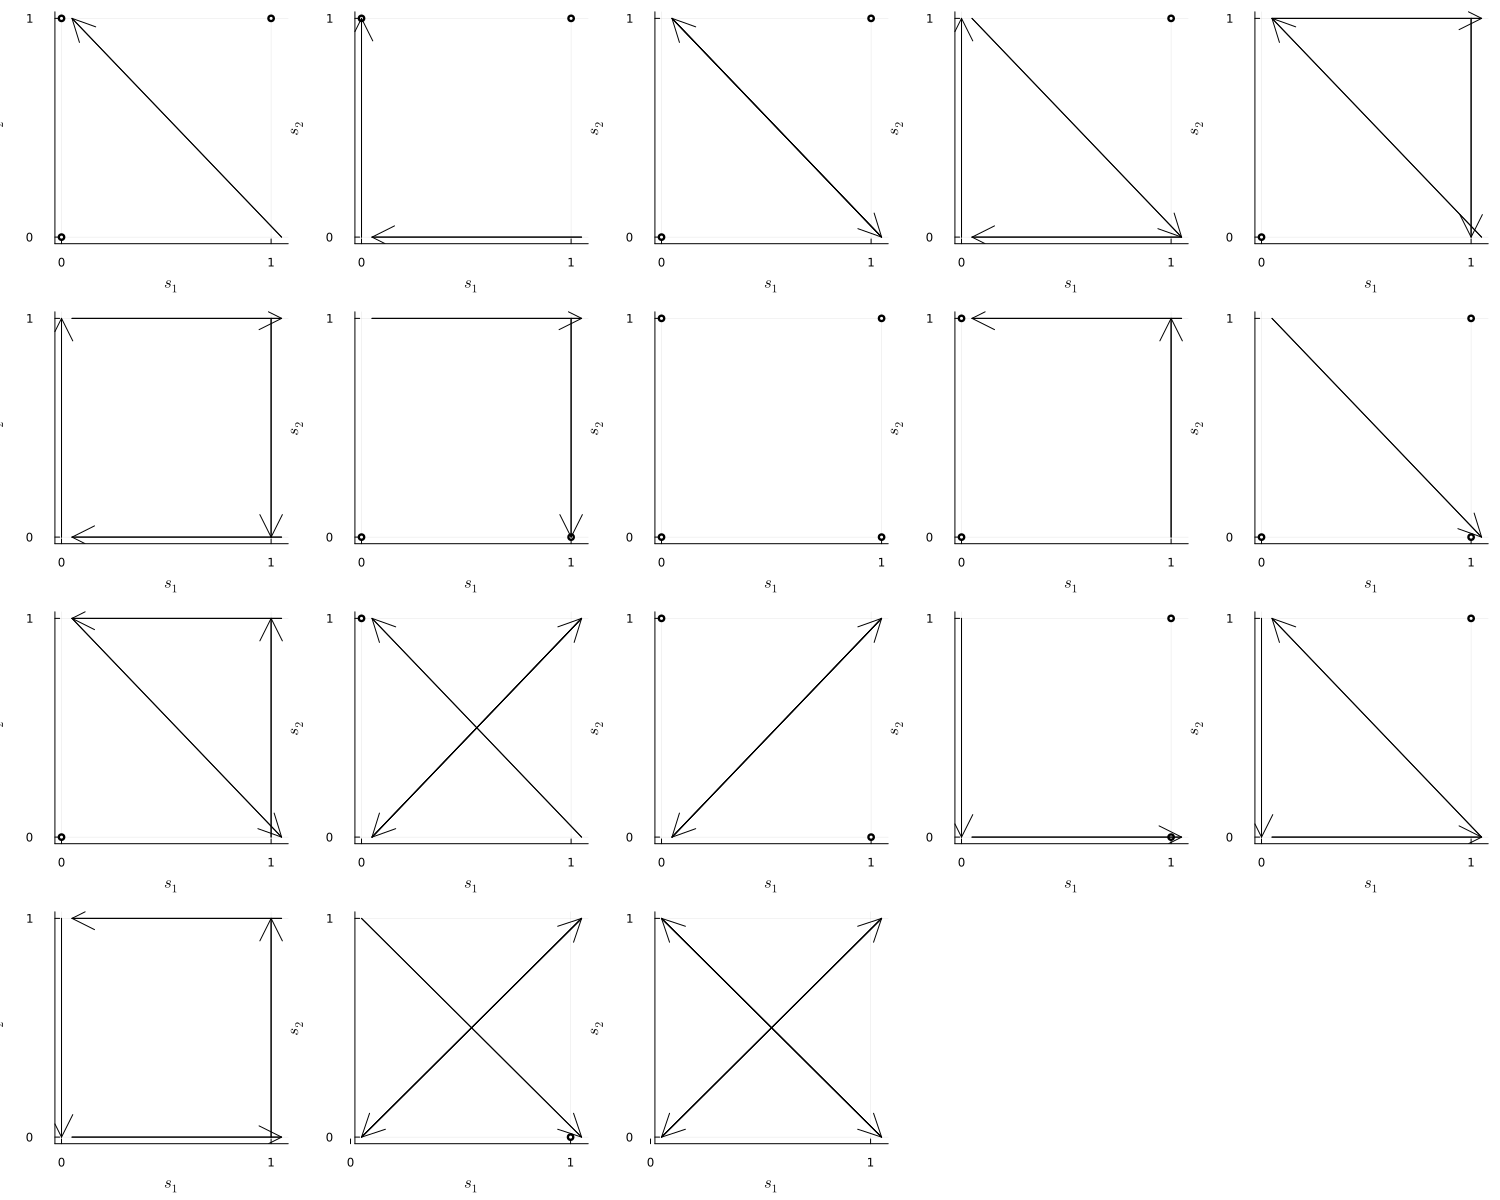

In [5]:
# display interactions
using Plots
plots = [interaction_plot(intr) for intr in interactions2]
plot(plots..., layout = 18, size = (1500, 1200))

## Combinatorics

The number of interactions is explosively increasing with the number of states.

The lower and upper bound of the number of interactions with respect to the number of states are given by the following way.
First we consider the class $\mathcal{I}'$ of interactions $\phi: S \times S \to S \times S$ which satisfy that $\hat{\iota}(\phi(\hat{\iota}(\phi(s_1, s_2)))) = (s_1, s_2)$ for *arbitrary* $s_1, s_2 \in S$.
With composing $\phi$ with $\hat{\iota}$ we can regard any interaction $\phi$ in $\mathcal{I}'$ as a directed graph $G_\phi$ on $S \times S$, which is symmetry and of indegree and outdegree 1 (can include loops).
The perspective gives us that the number of interactions in $\mathcal{I}'$ coincides to the number of (unnecessary to be complete) matchings on the complete graph $K_{\#S^2}$, which is known as the telephone number $T(\#S^2)$.

Moreover, we can see that every general interaction $\phi$ can be considered as some interaction $\phi'$ in $\mathcal{I}'$ which does not include an edge $(s_1, s_2) \to (s_2, s_1)$ for $s_1, s_2 \in S$, replaced some loops $(s_1, s_2) \to (s_1, s_2)$ into edges $(s_1, s_2) \to (s_2, s_1)$.
Now let $M$ be the matching on $K_{\#S^2}$ which corresponds with the interaction $\phi'$.
Then the choice of loops $(s_1, s_2) \to (s_1, s_2)$ where $s_1 \neq s_2$ occurs variations of interactions.
If let $\chi_{\phi'}$ be the number of loops $(s_1, s_2) \to (s_1, s_2)$ where $s_1 \neq s_2$ then the number of variations for $\phi' \in \mathcal{I}'$ is given by $2^{\chi_{\phi'}}$.
As $\#S(\#S-1) < \chi_{\phi'} < \#S^2$ we have the lower and upper bound
$$
    \sum_{k=0}^{\lfloor n^2/2 \rfloor} 2^{\#S(\#S-1)-2k} \#\{\text{$2k$-matchings on $K_{\#S^2} \setminus \bigsqcup_{\frac{1}{2}\#S(\#S-1)} K_2$}\} < \#\{\text{interactions on $S$}\} < \sum_{k=0}^{\lfloor n^2/2 \rfloor} 2^{\#S^2-2k} \#\{\text{$2k$-matchings on $K_{\#S^2} \setminus \bigsqcup_{\frac{1}{2}\#S(\#S-1)} K_2$}\},
$$
where the graph $K_{\#S^2} \setminus \bigsqcup_{\frac{1}{2}\#S(\#S-1)} K_2$ is the complete graph $K_{\#S^2}$ without $k$ co-prime edges.

In [6]:
# calculate lower and upper bounds for the number of interactions

odd_factorial(k) = k <= 1 ? 1 : big(k)*odd_factorial(k-2)

# number of 2k-matchings on n vertices
MK(n, k) = binomial(big(n), big(2k)) * odd_factorial(2k-1)

# number of 2k-matchings on K_{n^2} - K_2 * n(n-1)/2
# with the inclusion-exclusion principle(TODO: check carefully)
M(n, k) = sum([(-1)^i * MK(n^2-2i, k-i) * binomial(big(div(n*(n-1),2)), big(i)) for i in 0:k])

lower_bound(n :: Int) =
    sum([M(n, k) * 2.0^(n^2 - n - 2k) for k in 0:div(n^2, 2)])

upper_bound(n :: Int) =
    sum([M(n, k) * 2^(n^2 - 2k) for k in 0:div(n^2, 2)])

for i in 2:10
    println(Float64(lower_bound(i)), " < {interactions on #S=", i, "} < ", Float64(upper_bound(i)))
end

9.5 < {interactions on #S=2} < 38.0
3006.0 < {interactions on #S=3} < 24048.0
6.59988105e7 < {interactions on #S=4} < 1.055980968e9
1.75154630393214e14 < {interactions on #S=5} < 5.604948172582848e15
8.695721733439377e22 < {interactions on #S=6} < 5.565261909401202e24
1.15723398516633e34 < {interactions on #S=7} < 1.4812595010129024e36
5.6036736513899486e47 < {interactions on #S=8} < 1.4345404547558268e50
1.287464694228741e64 < {interactions on #S=9} < 6.591819234451154e66
1.7744693163905044e83 < {interactions on #S=10} < 1.8170565799838765e86


## The case of $\#S = 3$

Let us try to enumerate interactions on $S = \{0 = \ast, 1, 2\}$.

In [7]:
# #S = 3
state_size = 3
state_set = StateSet(state_size)
# interactions3 = enumerate_interactions(state_set)   # it costs about 14 minutes
interactions3 = enumerate_interactions(state_set, 10) # set time limit

# Variables: 180
# Constraints: 243
 - # Indicator: 81
 - # Reified: 162

  #Open    #Closed       Incumbent           Best Bound      Time [s] 
    2         0              -              0.0000000000      0.003   
    6         10             -              0.0000000000      0.006   
    9         19        0.0000000000        0.0000000000      0.008   
    10        32        0.0000000000        0.0000000000       0.09   
    14        42        0.0000000000        0.0000000000       0.09   
    16        54        0.0000000000        0.0000000000       0.10   
    16        64        0.0000000000        0.0000000000       0.10   
    7         79        0.0000000000        0.0000000000       0.12   
    7         91        0.0000000000        0.0000000000       0.13   
    16       102        0.0000000000        0.0000000000       0.13   
    8        116        0.0000000000        0.0000000000       0.15   
    9        127        0.0000000000        0.0000000000       0.15   
   


    10       1566       0.0000000000        0.0000000000       1.19   
    16       1576       0.0000000000        0.0000000000       1.20   
    12       1590       0.0000000000        0.0000000000       1.22   
    14       1600       0.0000000000        0.0000000000       1.23   
    8        1610       0.0000000000        0.0000000000       1.24   
    8        1620       0.0000000000        0.0000000000       1.25   
    12       1630       0.0000000000        0.0000000000       1.26   
    11       1641       0.0000000000        0.0000000000       1.27   
    10       1654       0.0000000000        0.0000000000       1.28   
    14       1664       0.0000000000        0.0000000000       1.28   
    16       1674       0.0000000000        0.0000000000       1.29   
    14       1684       0.0000000000        0.0000000000       1.29   
    11       1695       0.0000000000        0.0000000000       1.32   
    7        1705       0.0000000000        0.0000000000       1.33   
    1


    15       3167       0.0000000000        0.0000000000       2.23   
    14       3178       0.0000000000        0.0000000000       2.24   
    18       3188       0.0000000000        0.0000000000       2.25   
    12       3200       0.0000000000        0.0000000000       2.26   
    7        3211       0.0000000000        0.0000000000       2.27   
    17       3221       0.0000000000        0.0000000000       2.28   
    16       3232       0.0000000000        0.0000000000       2.29   
    11       3243       0.0000000000        0.0000000000       2.30   
    9        3255       0.0000000000        0.0000000000       2.31   
    13       3267       0.0000000000        0.0000000000       2.31   
    15       3277       0.0000000000        0.0000000000       2.32   
    15       3287       0.0000000000        0.0000000000       2.32   
    14       3300       0.0000000000        0.0000000000       2.33   
    15       3311       0.0000000000        0.0000000000       2.34   
    1

    9        4751       0.0000000000        0.0000000000       3.26   
    11       4761       0.0000000000        0.0000000000       3.26   
    9        4773       0.0000000000        0.0000000000       3.27   
    8        4784       0.0000000000        0.0000000000       3.29   
    11       4795       0.0000000000        0.0000000000       3.30   
    13       4805       0.0000000000        0.0000000000       3.31   
    17       4815       0.0000000000        0.0000000000       3.31   
    8        4828       0.0000000000        0.0000000000       3.32   
    12       4840       0.0000000000        0.0000000000       3.33   
    6        4854       0.0000000000        0.0000000000       3.34   
    14       4864       0.0000000000        0.0000000000       3.34   
    15       4875       0.0000000000        0.0000000000       3.35   
    14       4886       0.0000000000        0.0000000000       3.35   
    12       4896       0.0000000000        0.0000000000       3.36   
    13


    11       6323       0.0000000000        0.0000000000       4.27   
    9        6333       0.0000000000        0.0000000000       4.28   
    10       6344       0.0000000000        0.0000000000       4.29   
    10       6354       0.0000000000        0.0000000000       4.30   
    8        6364       0.0000000000        0.0000000000       4.31   
    13       6375       0.0000000000        0.0000000000       4.33   
    13       6385       0.0000000000        0.0000000000       4.34   
    12       6398       0.0000000000        0.0000000000       4.35   
    11       6409       0.0000000000        0.0000000000       4.38   
    10       6422       0.0000000000        0.0000000000       4.39   
    14       6432       0.0000000000        0.0000000000       4.39   
    12       6442       0.0000000000        0.0000000000       4.40   
    15       6453       0.0000000000        0.0000000000       4.40   
    11       6463       0.0000000000        0.0000000000       4.41   
    1


    12       7910       0.0000000000        0.0000000000       5.35   
    10       7920       0.0000000000        0.0000000000       5.36   
    14       7930       0.0000000000        0.0000000000       5.37   
    10       7940       0.0000000000        0.0000000000       5.38   
    8        7950       0.0000000000        0.0000000000       5.39   
    11       7961       0.0000000000        0.0000000000       5.39   
    9        7973       0.0000000000        0.0000000000       5.40   
    5        7987       0.0000000000        0.0000000000       5.41   
    10       7998       0.0000000000        0.0000000000       5.42   
    8        8008       0.0000000000        0.0000000000       5.43   
    7        8019       0.0000000000        0.0000000000       5.43   
    5        8029       0.0000000000        0.0000000000       5.44   
    9        8041       0.0000000000        0.0000000000       5.45   
    9        8051       0.0000000000        0.0000000000       5.45   
    9


    13       9523       0.0000000000        0.0000000000       6.44   
    13       9535       0.0000000000        0.0000000000       6.45   
    15       9545       0.0000000000        0.0000000000       6.47   
    10       9558       0.0000000000        0.0000000000       6.50   
    13       9569       0.0000000000        0.0000000000       6.51   
    14       9580       0.0000000000        0.0000000000       6.52   
    7        9595       0.0000000000        0.0000000000       6.54   
    13       9605       0.0000000000        0.0000000000       6.55   
    8        9618       0.0000000000        0.0000000000       6.56   
    9        9631       0.0000000000        0.0000000000       6.57   
    11       9641       0.0000000000        0.0000000000       6.57   
    10       9652       0.0000000000        0.0000000000       6.58   
    7        9667       0.0000000000        0.0000000000       6.62   
    10       9680       0.0000000000        0.0000000000       6.62   
    6


    11      11125       0.0000000000        0.0000000000       7.72   
    13      11135       0.0000000000        0.0000000000       7.73   
    13      11145       0.0000000000        0.0000000000       7.74   
    13      11155       0.0000000000        0.0000000000       7.75   
    7       11171       0.0000000000        0.0000000000       7.76   
    15      11181       0.0000000000        0.0000000000       7.77   
    17      11191       0.0000000000        0.0000000000       7.78   
    16      11202       0.0000000000        0.0000000000       7.79   
    18      11212       0.0000000000        0.0000000000       7.80   
    12      11222       0.0000000000        0.0000000000       7.81   
    10      11232       0.0000000000        0.0000000000       7.82   
    12      11242       0.0000000000        0.0000000000       7.82   
    10      11252       0.0000000000        0.0000000000       7.83   
    10      11264       0.0000000000        0.0000000000       7.84   
    1

    12      12674       0.0000000000        0.0000000000       8.89   
    12      12684       0.0000000000        0.0000000000       8.89   
    14      12694       0.0000000000        0.0000000000       8.90   
    12      12704       0.0000000000        0.0000000000       8.91   
    11      12715       0.0000000000        0.0000000000       8.92   
    13      12725       0.0000000000        0.0000000000       8.93   
    9       12735       0.0000000000        0.0000000000       8.94   
    14      12746       0.0000000000        0.0000000000       8.95   
    10      12756       0.0000000000        0.0000000000       8.96   
    10      12766       0.0000000000        0.0000000000       8.97   
    14      12776       0.0000000000        0.0000000000       8.97   
    14      12788       0.0000000000        0.0000000000       8.98   
    12      12798       0.0000000000        0.0000000000       8.98   
    12      12808       0.0000000000        0.0000000000       8.99   
    10

332-element Vector{Interaction}:
 Interaction(StateSet(3), LargeScaleInteractingSystems.InteractionsEnumeration.var"#3#6"{JuMP.Containers.DenseAxisArray{JuMP.VariableRef, 2, Tuple{UnitRange{Int64}, UnitRange{Int64}}, Tuple{JuMP.Containers._AxisLookup{Tuple{Int64, Int64}}, JuMP.Containers._AxisLookup{Tuple{Int64, Int64}}}}, JuMP.Containers.DenseAxisArray{JuMP.VariableRef, 2, Tuple{UnitRange{Int64}, UnitRange{Int64}}, Tuple{JuMP.Containers._AxisLookup{Tuple{Int64, Int64}}, JuMP.Containers._AxisLookup{Tuple{Int64, Int64}}}}, Int64}(2-dimensional DenseAxisArray{JuMP.VariableRef,2,...} with index sets:
    Dimension 1, 0:2
    Dimension 2, 0:2
And data, a 3×3 Matrix{JuMP.VariableRef}:
 φ2[0,0]  φ2[0,1]  φ2[0,2]
 φ2[1,0]  φ2[1,1]  φ2[1,2]
 φ2[2,0]  φ2[2,1]  φ2[2,2], 2-dimensional DenseAxisArray{JuMP.VariableRef,2,...} with index sets:
    Dimension 1, 0:2
    Dimension 2, 0:2
And data, a 3×3 Matrix{JuMP.VariableRef}:
 φ1[0,0]  φ1[0,1]  φ1[0,2]
 φ1[1,0]  φ1[1,1]  φ1[1,2]
 φ1[2,0]  φ1[2,1]  φ1

In [8]:
length(interactions3)

332

These are the initial 20 samples of interactions on $S = \{0 = \ast, 1, 2\}$.

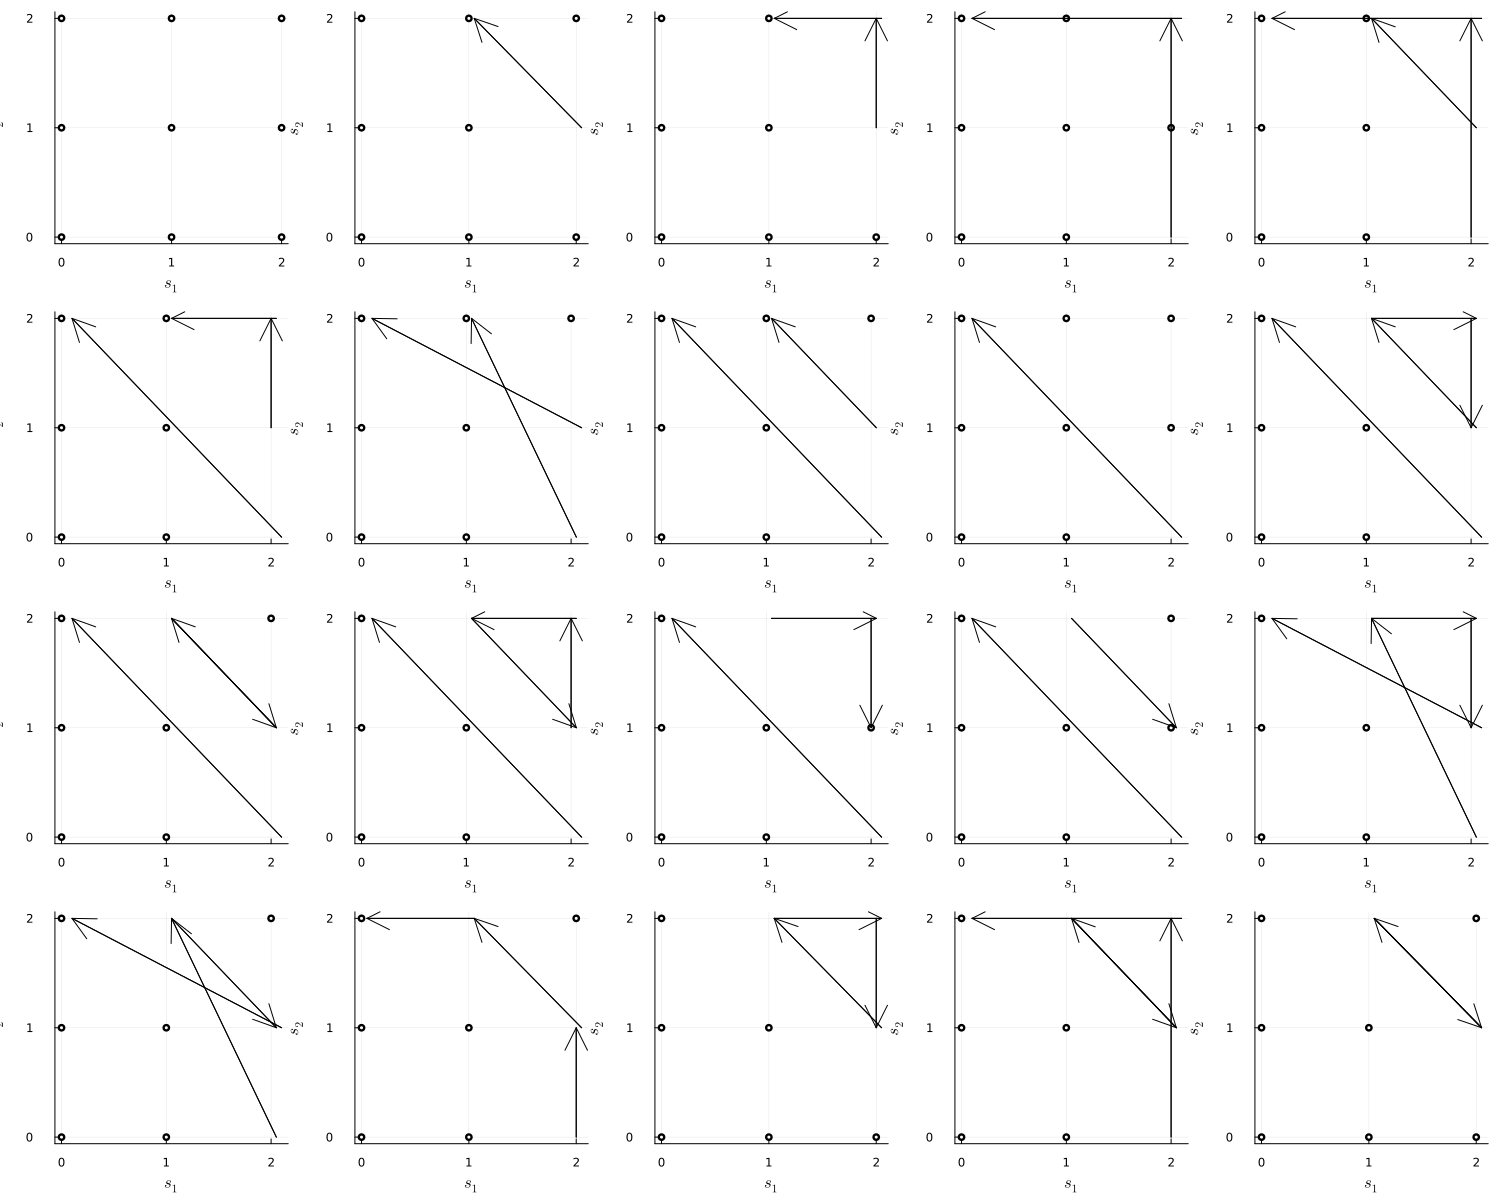

In [9]:
# display interactions
using Plots
n = 20
plots = [interaction_plot(interactions3[i]) for i in 1:n]
plot(plots..., layout = n, size = (1500, 1200))

## Conserved Quantities

In [10]:
cqs2 = [conserved_quantities(intr) for intr in interactions2]

332-element Vector{Nemo.fmpz_mat}:
 [1 0; 0 1]
 [1 0; 0 1]
 [1; 1]
 [1; 0]
 [1; 0]
 [1; 1]
 [0; 1]
 [1 0; 0 1]
 [1 0; 0 1]
 [1; 1]
 ⋮
 2 by 0 empty matrix
 2 by 0 empty matrix
 2 by 0 empty matrix
 2 by 0 empty matrix
 [2; 1]
 2 by 0 empty matrix
 2 by 0 empty matrix
 2 by 0 empty matrix
 2 by 0 empty matrix

In [22]:
cqs3 = [conserved_quantities(intr) for intr in interactions3]

332-element Vector{Nemo.fmpz_mat}:
 [1 0; 0 1]
 [1 0; 0 1]
 [1; 1]
 [1; 0]
 [1; 0]
 [1; 1]
 [0; 1]
 [1 0; 0 1]
 [1 0; 0 1]
 [1; 1]
 ⋮
 2 by 0 empty matrix
 2 by 0 empty matrix
 2 by 0 empty matrix
 2 by 0 empty matrix
 [2; 1]
 2 by 0 empty matrix
 2 by 0 empty matrix
 2 by 0 empty matrix
 2 by 0 empty matrix

## References

[1] [Bannai, Kenichi and Kametani, Yukio and Sasada, Makiko. Topological Structures of Large Scale Interacting Systems via Uniform Functions and Forms. 2020.](https://arxiv.org/abs/2009.04699v4)